# Interpretability pipeline development

We sketch and explore here the design of a pipeline to capture and analyze xAI in NCO.

In [1]:
import os
from pathlib import Path
from typing import List
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joypy

import tqdm

import torch
from torch import nn
from torch.utils.data import DataLoader
from captum.attr import IntegratedGradients, DeepLift

import logomaker

import NegativeClassOptimization.config as config
import NegativeClassOptimization.utils as utils
import NegativeClassOptimization.preprocessing as preprocessing
from NegativeClassOptimization import ml
from NegativeClassOptimization import datasets, pipelines, visualisations

/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [2]:
# TODO

# # Load from mlflow
# # Add ratios! of pos/neg
# # Add open set examples?

experiment_id = "11"
# run_name = "test"
run_id = "73a53fc4c0c74e7eababe4f1737cea0b"

# api = utils.MlflowAPI()
# r = api.mlflow_request(experiment_id, run_name)
# df = api.build_mlflow_results_df()
# df.head()

# # import requests

# # requests.get(
# #     "http://10.40.3.22:5000/api/2.0/mlflow/artifacts/list",
# #     json={
# #         "run_id": "73a53fc4c0c74e7eababe4f1737cea0b",
# #     },
# #     ).json()
# # # ftp_url = "ftp://eugen:33bY@U&ld&We@10.40.3.22/artifacts_store/11/73a53fc4c0c74e7eababe4f1737cea0b/artifacts/dataset/train_dataset.tsv/c35495f4_train_dataset.tsv"

# # # from urllib import request
# # # request.urlretrieve(ftp_url, filename=str("test.tsv"))

df_train_path = "../data/nco_mlflow_runs/ftp/artifacts_store/11/73a53fc4c0c74e7eababe4f1737cea0b/artifacts/dataset/train_dataset.tsv/c35495f4_train_dataset.tsv"
df_test_path = "../data/nco_mlflow_runs/ftp/artifacts_store/11/73a53fc4c0c74e7eababe4f1737cea0b/artifacts/dataset/test_dataset.tsv/c35495f4_test_dataset.tsv"
model_path = "../data/nco_mlflow_runs/ftp/artifacts_store/11/73a53fc4c0c74e7eababe4f1737cea0b/artifacts/models/trained_model"

1. Define and preprocess relevant pipeline inputs

In [3]:
ag_pos = "3VRL"
ag_neg = "1NSN"
df_para = utils.load_paratopes()

df = utils.load_global_dataframe()
df_train = pd.read_csv(df_train_path, sep="\t")
df_test = pd.read_csv(df_test_path, sep="\t")
model = torch.load(Path(model_path) / "data/model.pth")

attributors = [
    # ml.Attributor(
    #     model, 
    #     type="integrated_gradients", 
    #     baseline_type="zero", 
    #     compute_on="logits"
    #     ),
    # ml.Attributor(model,
    #     type="integrated_gradients", 
    #     baseline_type="shuffle",
    #     compute_on="logits"
    #     ),
    ml.Attributor(model,
        type="deep_lift", 
        baseline_type="zero",
        compute_on="logits",
        multiply_by_inputs=True,
        ),
    ml.Attributor(model,
        type="deep_lift", 
        baseline_type="zero",
        compute_on="logits",
        multiply_by_inputs=False,
        ),
    ml.Attributor(model,
        type="deep_lift", 
        baseline_type="shuffle",
        compute_on="logits",
        multiply_by_inputs=True,
        ),
    ml.Attributor(model,
        type="deep_lift", 
        baseline_type="shuffle",
        compute_on="logits",
        multiply_by_inputs=False,
        ),
    # ml.Attributor(model, type="deep_lift", baseline_type="zero", compute_on="logits"),
    # ml.Attributor(model, type="deep_lift", baseline_type="shuffle", compute_on="logits"),
]

In [4]:
df_train.head()

,Slide,binds_a_pos_ag,Slide_farmhash_mod_32768,Slide_onehot,X,y
0,AAELFWYFDVW,1,3177,[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,1
1,AAGYFFYFDVW,1,1605,[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,1
2,AALLPIRPDGY,0,736,[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,0
3,AASFGWDVGYF,0,2363,[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,0
4,ADDYDLGVFPF,0,2068,[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,0


In [6]:
N = 1000
res = {}

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for row in df_train.sample(N).iterrows():
        slide = row[1]["Slide"]
        binds_a_pos_ag = row[1]["binds_a_pos_ag"]

        # Model predictions and basic parameters
        is_slide_in_train = slide in df_train["Slide"]
        enc = torch.tensor(preprocessing.onehot_encode(slide)).float().reshape((1, -1))
        expits, logits = model.forward(enc, return_logits=True)
        y_pred = expits.round()
        y_true = binds_a_pos_ag
        is_pred_correct = bool((y_pred == y_true)[0][0])
        # print(f"{y_pred=} ? {y_true=} => {is_pred_correct=}")

        # Attributions
        res_attr = {}
        for attributor in attributors:
            attributions, baseline = attributor.attribute(enc, return_baseline=True)
            baseline_expits, baseline_logits = model.forward(baseline, return_logits=True)
            res_attr[attributor.name] = {
                "attributions": attributions,
                "baseline": baseline,
                "baseline_logits": baseline_logits,
                "baseline_expits": baseline_expits,
            }

        # Record results
        res[slide] = {
            "enc": enc,
            "logits": logits,
            "expits": expits,
            "y_pred": y_pred,
            "y_true": y_true,
            "is_pred_correct": is_pred_correct,
            "attributions": res_attr,
        }


# Transform results into a dataframe
df = pd.DataFrame.from_dict(res, orient="index")
df = df.sort_values("logits", ascending=False)
df.reset_index(inplace=True)
df.rename(columns={"index": "slide"}, inplace=True)

df["logits"] = df["logits"].astype(float)
df["expits"] = df["expits"].astype(float)
df["y_pred"] = df["y_pred"].astype(int)

df.head()

,slide,enc,logits,expits,y_pred,y_true,is_pred_correct,attributions
0,IRGIMVITALF,"[[tensor(0.), tensor(0.), tensor(0.), tensor(0...",26.754543,1.0,1,1,True,{'deep_lift__logits__zero__multiplyTrue': {'at...
1,CARLLLITTVL,"[[tensor(0.), tensor(1.), tensor(0.), tensor(0...",21.301992,1.0,1,1,True,{'deep_lift__logits__zero__multiplyTrue': {'at...
2,CARWLLLLAWF,"[[tensor(0.), tensor(1.), tensor(0.), tensor(0...",18.974049,1.0,1,1,True,{'deep_lift__logits__zero__multiplyTrue': {'at...
3,CARIALLLYYF,"[[tensor(0.), tensor(1.), tensor(0.), tensor(0...",18.479233,1.0,1,1,True,{'deep_lift__logits__zero__multiplyTrue': {'at...
4,CARWLLLFYYF,"[[tensor(0.), tensor(1.), tensor(0.), tensor(0...",17.656433,1.0,1,1,True,{'deep_lift__logits__zero__multiplyTrue': {'at...


In [7]:
def filter_res_for_selected_attributor(df: pd.DataFrame, attributor_sel: str):
    """Filter df for selected attributor.
    Returns:
        - df_sel: df with selected attributor (Num_slides x #cols(df))
        - df_attr: df with attributions per slide (Num_slides x 220)
    """
    records = []
    for row in df.iterrows():
        s = row[1]
        attr_data = s["attributions"][attributor_sel]
        new_row_dict = {
            **dict(s),
            **attr_data,
        }
        records.append(new_row_dict)

    df_sel = pd.DataFrame.from_records(records)
    df_sel["baseline_logits"] = df_sel["baseline_logits"].astype(float)
    df_sel["baseline_expits"] = df_sel["baseline_expits"].astype(float)
    # df_attr = pd.DataFrame(np.concatenate(df_sel["attributions"].map(lambda x: x.detach().numpy()), axis=0))
    
    return df_sel  #, df_attr


def get_df_sel(attributor_sel, df, df_para):
    """Get df_sel for selected attributor."""
    df_sel = filter_res_for_selected_attributor(df, attributor_sel)
    df_sel["Antigen"] = np.where(df_sel["y_true"] == 1, ag_pos, ag_neg)
    df_sel = pd.merge(df_sel, df_para, how="left", left_on=("slide", "Antigen"), right_on=("Slide", "Antigen"))
    return df_sel

## Case studies

For each case, we draw logos:
1. Sequence logo
2. Paratope logo
3. Deeplift with `multiply_by_inputs`
4. Deeplift without `multiply_by_inputs`

We examine 2 slides per each case:
1. Strong positive prediction
2. Strong negative prediction
3. Prediction close to 0

In [8]:
attributor_sel_1 = attributors[-1].name  # without multiply_by_inputs
attributor_sel_2 = attributors[-2].name  # with multiply_by_inputs

# Create df_sel per attributor
df_sel_1 = get_df_sel(attributor_sel_1, df, df_para)
df_sel_2 = get_df_sel(attributor_sel_2, df, df_para)

df_sel_1

,slide,enc,logits,expits,y_pred,y_true,is_pred_correct,attributions,baseline,baseline_logits,baseline_expits,Antigen,Slide,Label,hotspot_ID,agregatesAGEpitope,agregatesABParatope
0,IRGIMVITALF,"[[tensor(0.), tensor(0.), tensor(0.), tensor(0...",26.754543,1.000000e+00,1,1,True,"[[tensor(-0.8626), tensor(1.3797), tensor(-6.5...","[[tensor(0.0970), tensor(0.), tensor(0.), tens...",2.557039,0.928045,3VRL,IRGIMVITALF,3VRL_C,3VRL_C_H1,D1T2L2--V1Q1--A1--P1--C3K1--L1--A1L2G1P1--A1T1,I2R1G1I3M3V3I1--A1L2F4*
1,CARLLLITTVL,"[[tensor(0.), tensor(1.), tensor(0.), tensor(0...",21.301992,1.000000e+00,1,1,True,"[[tensor(-0.8345), tensor(1.4031), tensor(-6.4...","[[tensor(0.1080), tensor(0.0920), tensor(0.), ...",1.054212,0.741583,3VRL,CARLLLITTVL,3VRL_C,3VRL_C_H1,D1T2L2--V1Q1--A1--P1--C3K1--L1--A1L2G1P1--A1T1,C2A1R1L3L3L3I1--T1V2L4*
2,CARWLLLLAWF,"[[tensor(0.), tensor(1.), tensor(0.), tensor(0...",18.974049,1.000000e+00,1,1,True,"[[tensor(-0.8660), tensor(1.3772), tensor(-6.5...","[[tensor(0.1850), tensor(0.0950), tensor(0.), ...",0.774024,0.684391,3VRL,CARWLLLLAWF,3VRL_C,3VRL_C_H1,D1T1L2--V1Q1--A1--P1--C3K1--L1--A1L3G1P2--A1T1,C2A1--W2L1L3L3L3A1W2F4*
3,CARIALLLYYF,"[[tensor(0.), tensor(1.), tensor(0.), tensor(0...",18.479233,1.000000e+00,1,1,True,"[[tensor(-0.8652), tensor(1.3776), tensor(-6.5...","[[tensor(0.1890), tensor(0.0970), tensor(0.), ...",1.287033,0.783645,3VRL,CARIALLLYYF,3VRL_C,3VRL_C_H1,D1T1L2--V1Q1--A1--P1--C3K1--L1--A1L3G1P2--A1T1,C2A1--I2A1L3L3L3Y1Y2F4*
4,CARWLLLFYYF,"[[tensor(0.), tensor(1.), tensor(0.), tensor(0...",17.656433,1.000000e+00,1,1,True,"[[tensor(-0.8652), tensor(1.3776), tensor(-6.5...","[[tensor(0.1080), tensor(0.0990), tensor(0.), ...",3.220764,0.961608,3VRL,CARWLLLFYYF,3VRL_C,3VRL_C_H1,D1T1L2--V1Q1--A1--P1--C3K1--L1--A1L3G1P2--A1T1,C2A1--W2L1L3L3F3Y1Y2F4*
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,WFDYDEGFAYW,"[[tensor(0.), tensor(0.), tensor(0.), tensor(0...",-16.895769,4.594737e-08,0,0,True,"[[tensor(-1.7696), tensor(-1.1025), tensor(-2....","[[tensor(0.0910), tensor(0.), tensor(0.1540), ...",-8.867853,0.000141,1NSN,WFDYDEGFAYW,1NSN_S,1NSN_S_H1,I1D1--T1V1K1--M1T1--V1--T1--Q1--D1--Y1G1R4G1--...,W3F3D2Y4--E2--F3A1Y2W4*
996,YRGSSLSWFAY,"[[tensor(0.), tensor(0.), tensor(0.), tensor(0...",-17.013094,4.086083e-08,0,0,True,"[[tensor(-1.7696), tensor(-1.1025), tensor(-2....","[[tensor(0.0890), tensor(0.), tensor(0.), tens...",-8.508659,0.000202,1NSN,YRGSSLSWFAY,1NSN_S,1NSN_S_H1,I1K1--I2D1--T1V1K1--P1M1T1--V1--T1--Q1--D1K1Y1...,Y4R2G1S2--L4S2W3F3A2Y2*
997,FYDYDERFAYW,"[[tensor(0.), tensor(0.), tensor(0.), tensor(0...",-17.047270,3.948796e-08,0,0,True,"[[tensor(-1.8081), tensor(-1.0451), tensor(-2....","[[tensor(0.0990), tensor(0.), tensor(0.1640), ...",-9.385227,0.000084,1NSN,FYDYDERFAYW,1NSN_S,1NSN_S_H1,I1D1--T1V1K1--M1T1--V1--T1--Q1--D1--Y1G1R4G1--...,F4Y2D1Y3--E2--F4A2Y3W3*
998,NYDYDLAWFAY,"[[tensor(0.), tensor(0.), tensor(0.), tensor(0...",-17.603275,2.264616e-08,0,0,True,"[[tensor(-1.7646), tensor(-1.1004), tensor(-2....","[[tensor(0.1770), tensor(0.), tensor(0.1660), ...",-8.274181,0.000255,1NSN,NYDYDLAWFAY,1NSN_S,1NSN_S_H1,I1K1--I2D1--T1V1K1--P1M1T1--V1--T1--Q1--D1K1Y1...,N4Y2D1Y2--L4A2W3F3A2Y2*


<AxesSubplot: xlabel='logits', ylabel='is_pred_correct'>

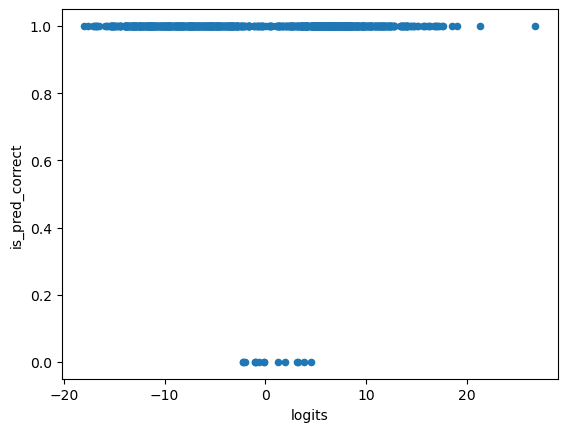

In [9]:
df_sel_1["is_pred_correct"] = df_sel_1["is_pred_correct"].astype(int)
df_sel_1.plot.scatter(x="logits", y="is_pred_correct")

In [10]:
df_sel_1.loc[df_sel_1["is_pred_correct"] == 0]

,slide,enc,logits,expits,y_pred,y_true,is_pred_correct,attributions,baseline,baseline_logits,baseline_expits,Antigen,Slide,Label,hotspot_ID,agregatesAGEpitope,agregatesABParatope
400,LLLWLYYFDYW,"[[tensor(0.), tensor(0.), tensor(0.), tensor(0...",4.544394,0.989485,1,0,0,"[[tensor(-0.7516), tensor(1.2298), tensor(-5.1...","[[tensor(0.), tensor(0.), tensor(0.0970), tens...",0.955880,0.722296,1NSN,LLLWLYYFDYW,1NSN_S,1NSN_S_H1,I2D3--D1T1V1K1--M1T1--V1--T2--E1--K1H1--Y1G1R1...,L4L2L4W1L1--Y3F3--Y1W2*
426,WLLLFYAMDYW,"[[tensor(0.), tensor(0.), tensor(0.), tensor(0...",3.862991,0.979427,1,0,0,"[[tensor(-0.7450), tensor(1.2235), tensor(-5.1...","[[tensor(0.0850), tensor(0.), tensor(0.0810), ...",-0.116190,0.470985,1NSN,WLLLFYAMDYW,1NSN_S,1NSN_S_H1,I1--I1D3--D1T1V1K1--P1M1T1--V1--T2--E1--K1H1--...,W2L3L3L2F4--A1--D2Y1W4*
447,LLLRILYFDYW,"[[tensor(0.), tensor(0.), tensor(0.), tensor(0...",3.249935,0.962671,1,0,0,"[[tensor(-0.7413), tensor(1.2200), tensor(-5.1...","[[tensor(0.), tensor(0.), tensor(0.0750), tens...",0.785053,0.686768,1NSN,LLLRILYFDYW,1NSN_S,1NSN_S_H1,I1--I1D2--D1T1V1K1--P1M1T1--V1--T3--E1--H1--K1...,L2L3L3--I1L2Y4F1D2--W4*
451,LLDGNFLLDYW,"[[tensor(0.), tensor(0.), tensor(0.), tensor(0...",3.188397,0.960395,1,0,0,"[[tensor(-0.4875), tensor(0.4384), tensor(-3.7...","[[tensor(0.), tensor(0.), tensor(0.1880), tens...",-3.878592,0.020261,1NSN,LLDGNFLLDYW,1NSN_S,1NSN_S_H1,I2D3--D1T1V1K1--M1T1--V1--T2--E1--K1H1--Y1G1R1...,L3L3--G1--F4L2L4D1Y2W1*
479,GVLLWLRLYYF,"[[tensor(0.), tensor(0.), tensor(0.), tensor(0...",1.946937,0.875112,1,0,0,"[[tensor(-0.7884), tensor(1.2731), tensor(-5.5...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0...",2.204963,0.900694,1NSN,GVLLWLRLYYF,1NSN_S,1NSN_S_H1,I1K1--I2D2--D1T1V1K1--P1M1T1--V1--T2--E1--H1--...,V4L2L4W1L1--L3Y3Y2F2*
492,LGGWLLREVWF,"[[tensor(0.), tensor(0.), tensor(0.), tensor(0...",1.227411,0.773365,1,0,0,"[[tensor(-0.6408), tensor(1.0247), tensor(-4.6...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0...",-3.423046,0.031583,1NSN,LGGWLLREVWF,1NSN_S,1NSN_S_H1,I1--I1D2--D1T1V1K1--P1M1T1--V1--T3--E1--H1--K1...,L4--G2W1L4L2R1--V3W3F2*
505,ARLLLLRHWYF,"[[tensor(1.), tensor(0.), tensor(0.), tensor(0...",-0.140156,0.465018,0,1,0,"[[tensor(-0.4587), tensor(0.7041), tensor(-3.8...","[[tensor(0.0880), tensor(0.), tensor(0.), tens...",-1.374978,0.201817,3VRL,ARLLLLRHWYF,3VRL_C,3VRL_C_H1,D1T2L2--V1Q1--A1--P1--C3K1--L1--A1L2G1P1--A1T1,A2R1L1L3L3L3R1--W1Y2F4*
506,LRLLPLGFAYW,"[[tensor(0.), tensor(0.), tensor(0.), tensor(0...",-0.158144,0.460546,0,1,0,"[[tensor(-1.0941), tensor(1.0048), tensor(-5.3...","[[tensor(0.0830), tensor(0.), tensor(0.), tens...",-2.040118,0.115055,3VRL,LRLLPLGFAYW,3VRL_C,3VRL_C_H1,D1T1L2--V1Q1--A1--P1--C3K1--L1--A1L3G1P2--A1T1,L4R2L1L3P3L3G1F2--Y1W2*
516,LLLRYKLGYFD,"[[tensor(0.), tensor(0.), tensor(0.), tensor(0...",-0.671227,0.338222,0,1,0,"[[tensor(-0.3766), tensor(-0.2916), tensor(-1....","[[tensor(0.), tensor(0.), tensor(0.0860), tens...",-3.676345,0.024690,3VRL,LLLRYKLGYFD,3VRL_C,3VRL_C_H1,D1T1L2--V1Q1--A1--P1--C2K1--L1--L3G1P2--A1T1,L3L3L3R1Y2--L1G1Y2F4*
520,RWLLPLNYWYF,"[[tensor(0.), tensor(0.), tensor(0.), tensor(0...",-0.874315,0.294357,0,1,0,"[[tensor(-0.4213), tensor(0.6037), tensor(-3.6...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0...",-1.738310,0.149528,3VRL,RWLLPLNYWYF,3VRL_C,3VRL_C_H1,D1T1L2--V1Q1--A1--P1--C2K1--L1--L3G1P2--A1T1,W3L3L3P1L2--Y1W1Y2F4*


In [11]:
def plot_attribution_report_by_index(idx_1, df_sel_1, df_sel_2):
    row_sel_1_idx_1 = df_sel_1.iloc[idx_1]
    row_sel_2_idx_1 = df_sel_2.iloc[idx_1]

    print(row_sel_1_idx_1['slide'])

    fig, axs = plt.subplots(2, 2, figsize=(14, 7))
    fig.suptitle(
    f"Slide: {row_sel_1_idx_1['slide']}, y_true: {row_sel_1_idx_1['y_true']}, y_pred: {row_sel_1_idx_1['y_pred']}, "
    f"logits={row_sel_1_idx_1['logits']:0.2f}, expits={row_sel_1_idx_1['expits']:0.2f}",
    fontsize=16)

    ## Sequence
    visualisations.plot_logo(
        pd.DataFrame(
            row_sel_1_idx_1["enc"].numpy().reshape((-1, 20)), 
            columns=config.AMINOACID_ALPHABET
            ),
        ax=axs[0, 0],
    )
    axs[0, 0].set_title("Sequence")

    ## Paratope
    visualisations.plot_logo(
        pd.DataFrame(
            preprocessing.onehot_encode_deg_paratope(row_sel_1_idx_1["agregatesABParatope"]).reshape((-1, 20)), 
            columns=config.AMINOACID_ALPHABET
            ),
        ax=axs[0, 1],
    )
    axs[0, 1].set_title("Paratope with #contacts")
    
    ## Attributions: Deeplift w/ multiply by input
    visualisations.plot_logo(
        pd.DataFrame(
            row_sel_2_idx_1["attributions"].detach().numpy().reshape((-1, 20)), 
            columns=config.AMINOACID_ALPHABET
            ),
        ax=axs[1, 0],
    )
    axs[1, 0].set_title("('Global' Attributions): Deeplift with `multiply by input`")

    ## Attributions: Deeplift w/o multiply by input
    visualisations.plot_logo(
        pd.DataFrame(
            row_sel_1_idx_1["attributions"].detach().numpy().reshape((-1, 20)), 
            columns=config.AMINOACID_ALPHABET
            ),
        ax=axs[1, 1],
    )
    axs[1, 1].set_title("('Local' Attributions): Deeplift without `multiply by input`")

Slides case 1: strong positive prediction

IRGIMVITALF


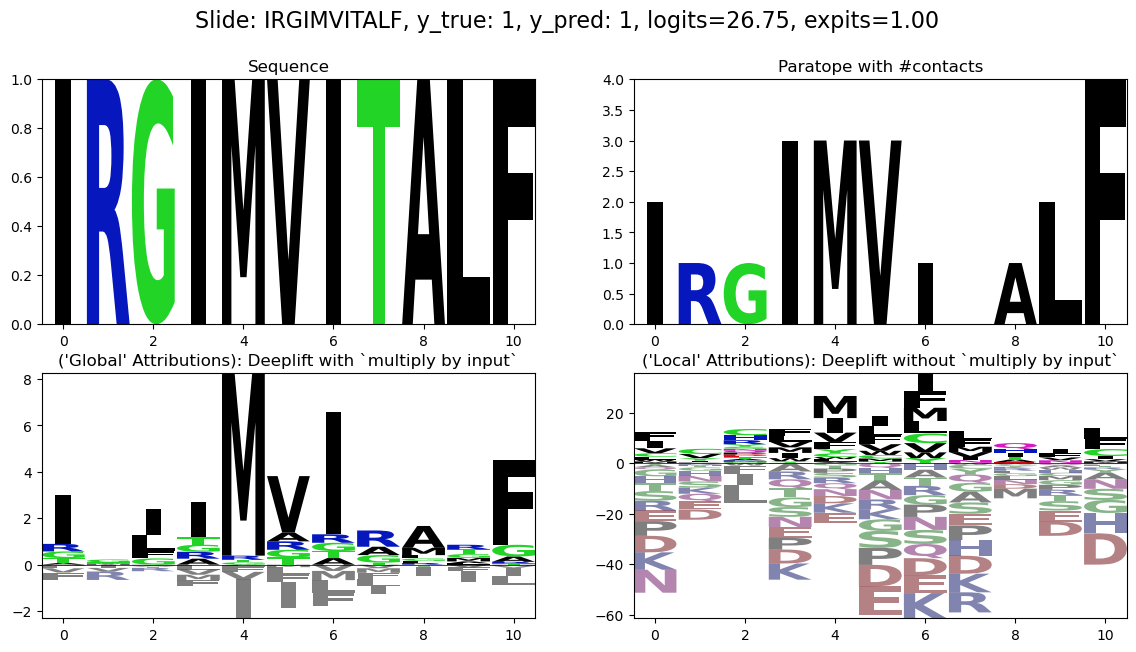

In [13]:
plot_attribution_report_by_index(int(0*N/100), df_sel_1, df_sel_2)

CARWRLLFYYF


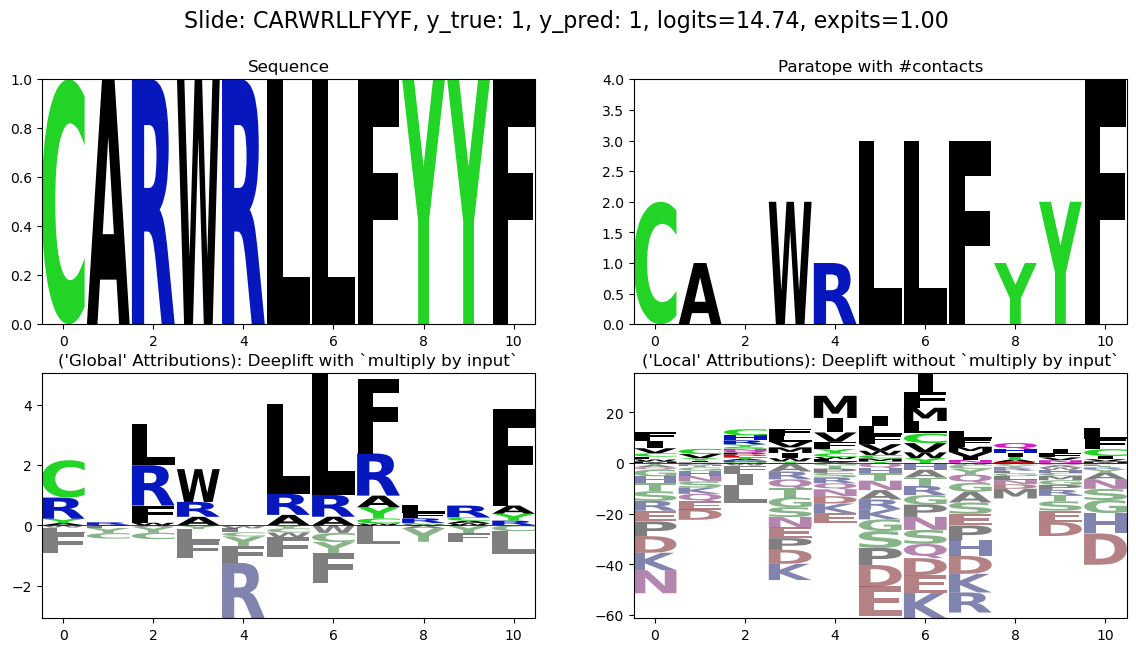

In [14]:
plot_attribution_report_by_index(int(2*N/100), df_sel_1, df_sel_2)

GVALYWYFDVW


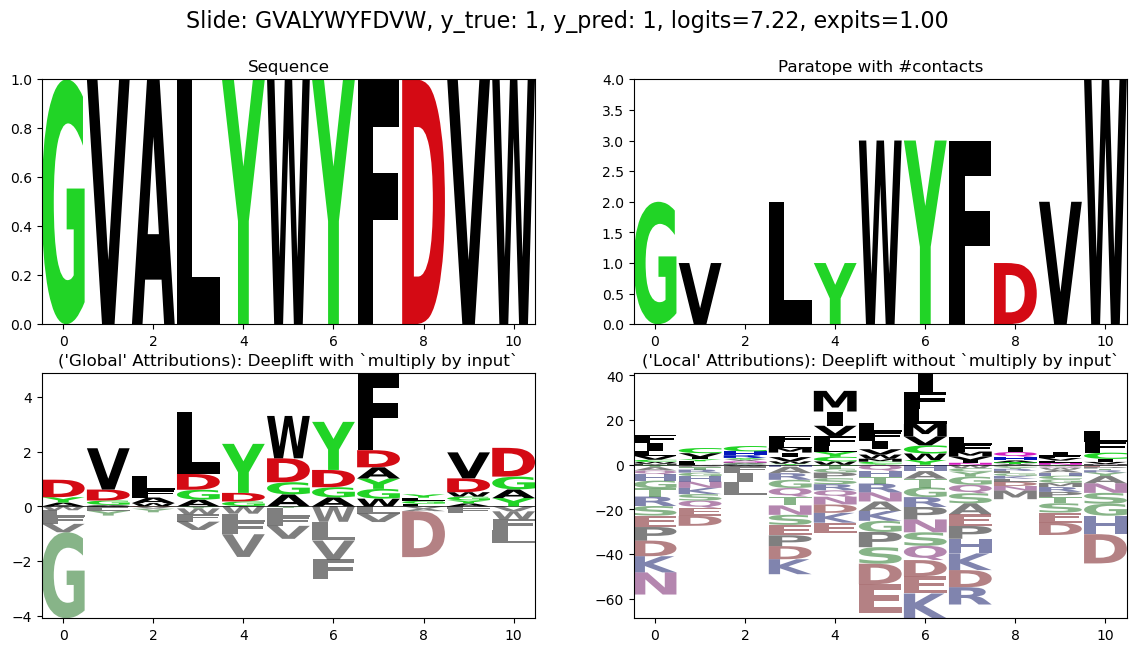

In [15]:
plot_attribution_report_by_index(int(24*N/100), df_sel_1, df_sel_2)

Slides case 2: unconfident, near 0 predictions

LLLWLYYFDYW


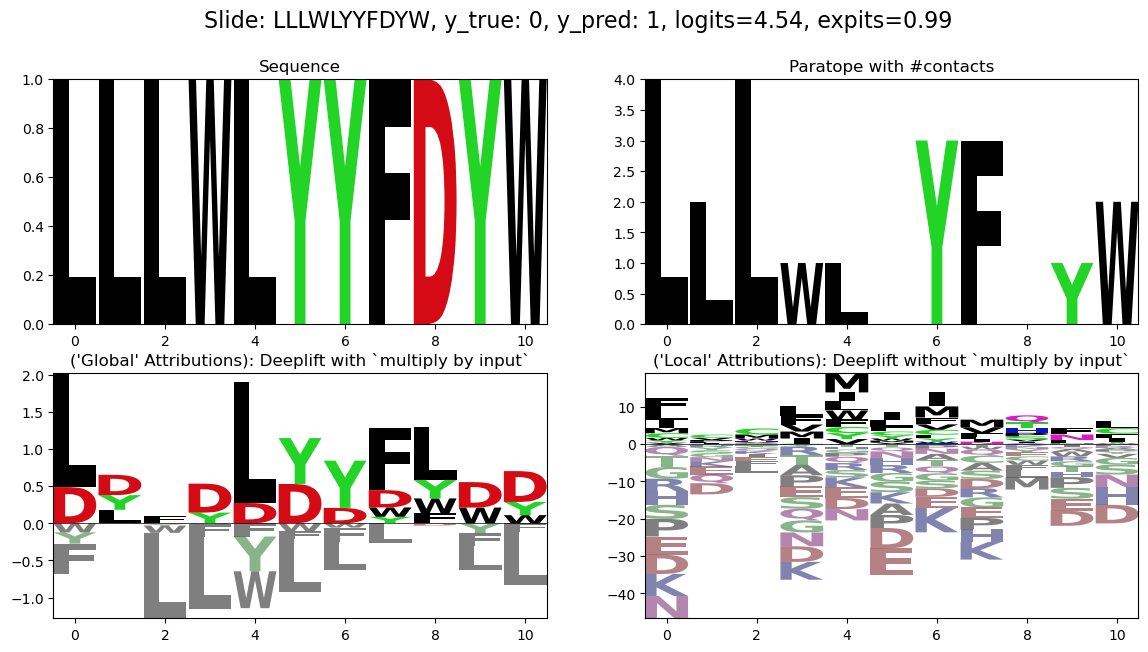

In [16]:
plot_attribution_report_by_index(int(40*N/100), df_sel_1, df_sel_2)
# Unconfident because saw a D at position 4, and 8?

CARLQLRLPWF


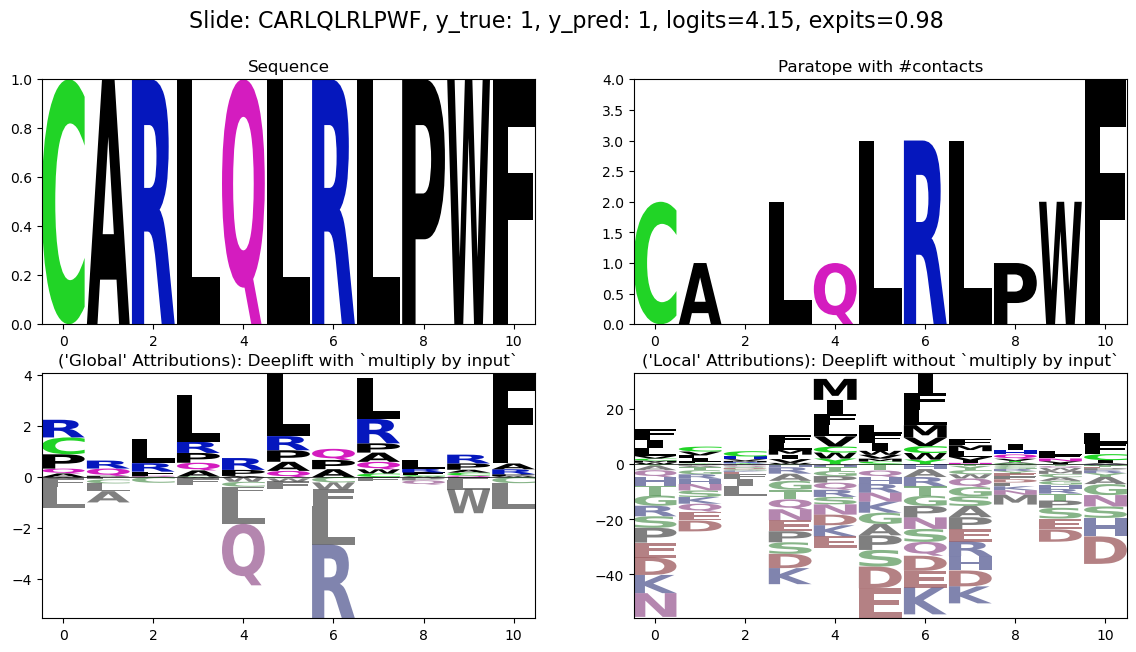

In [17]:
plot_attribution_report_by_index(int(41*N/100), df_sel_1, df_sel_2)

Slides case 3: confident, negative predictions

RWLLDPTILYV


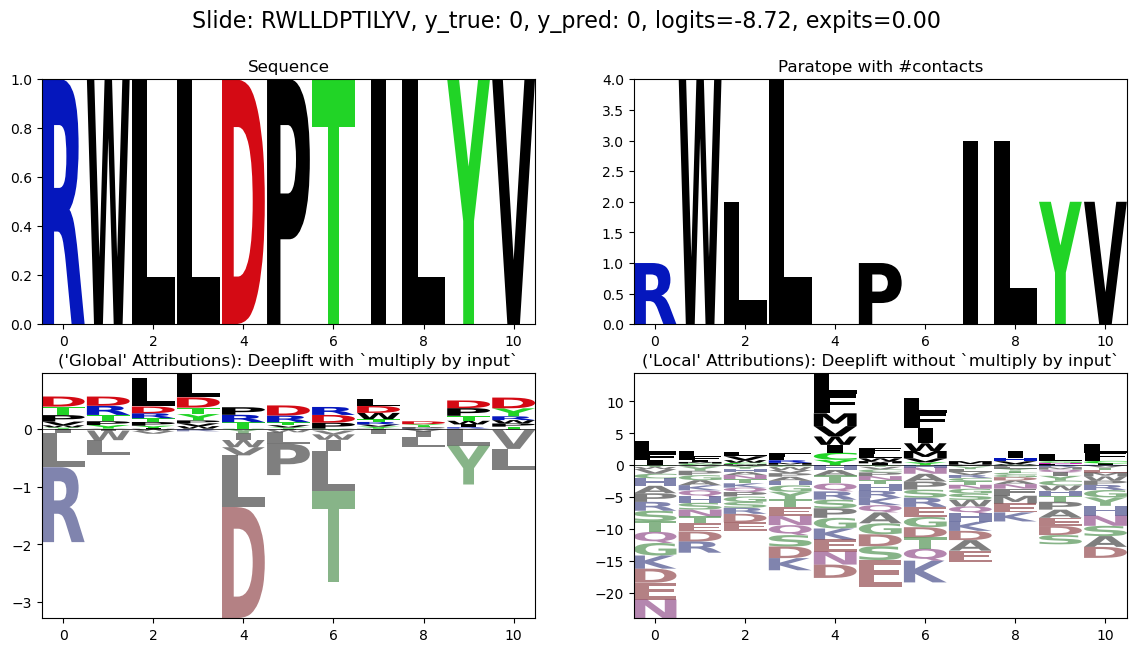

In [18]:
plot_attribution_report_by_index(int(77*N/100), df_sel_1, df_sel_2)

VDDYDVAWFAY


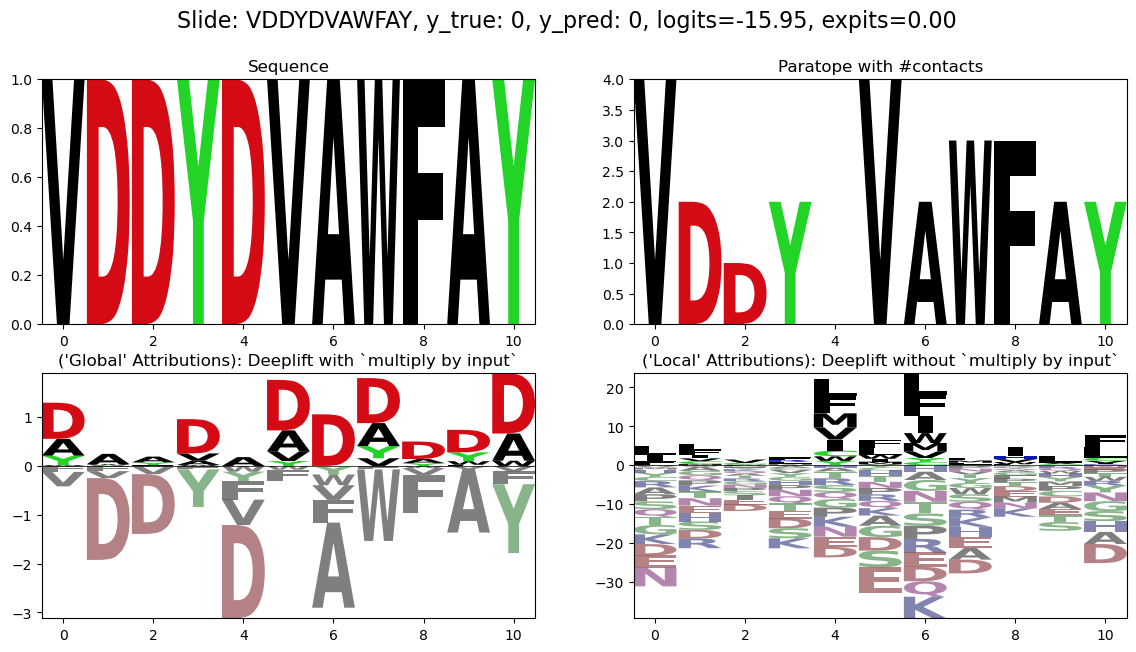

In [19]:
plot_attribution_report_by_index(int(99*N/100), df_sel_1, df_sel_2)

## Compute mistakes between attributions and paratopes.

In [20]:
df_sel_1

,slide,enc,logits,expits,y_pred,y_true,is_pred_correct,attributions,baseline,baseline_logits,baseline_expits,Antigen,Slide,Label,hotspot_ID,agregatesAGEpitope,agregatesABParatope
0,IRGIMVITALF,"[[tensor(0.), tensor(0.), tensor(0.), tensor(0...",26.754543,1.000000e+00,1,1,1,"[[tensor(-0.8626), tensor(1.3797), tensor(-6.5...","[[tensor(0.0970), tensor(0.), tensor(0.), tens...",2.557039,0.928045,3VRL,IRGIMVITALF,3VRL_C,3VRL_C_H1,D1T2L2--V1Q1--A1--P1--C3K1--L1--A1L2G1P1--A1T1,I2R1G1I3M3V3I1--A1L2F4*
1,CARLLLITTVL,"[[tensor(0.), tensor(1.), tensor(0.), tensor(0...",21.301992,1.000000e+00,1,1,1,"[[tensor(-0.8345), tensor(1.4031), tensor(-6.4...","[[tensor(0.1080), tensor(0.0920), tensor(0.), ...",1.054212,0.741583,3VRL,CARLLLITTVL,3VRL_C,3VRL_C_H1,D1T2L2--V1Q1--A1--P1--C3K1--L1--A1L2G1P1--A1T1,C2A1R1L3L3L3I1--T1V2L4*
2,CARWLLLLAWF,"[[tensor(0.), tensor(1.), tensor(0.), tensor(0...",18.974049,1.000000e+00,1,1,1,"[[tensor(-0.8660), tensor(1.3772), tensor(-6.5...","[[tensor(0.1850), tensor(0.0950), tensor(0.), ...",0.774024,0.684391,3VRL,CARWLLLLAWF,3VRL_C,3VRL_C_H1,D1T1L2--V1Q1--A1--P1--C3K1--L1--A1L3G1P2--A1T1,C2A1--W2L1L3L3L3A1W2F4*
3,CARIALLLYYF,"[[tensor(0.), tensor(1.), tensor(0.), tensor(0...",18.479233,1.000000e+00,1,1,1,"[[tensor(-0.8652), tensor(1.3776), tensor(-6.5...","[[tensor(0.1890), tensor(0.0970), tensor(0.), ...",1.287033,0.783645,3VRL,CARIALLLYYF,3VRL_C,3VRL_C_H1,D1T1L2--V1Q1--A1--P1--C3K1--L1--A1L3G1P2--A1T1,C2A1--I2A1L3L3L3Y1Y2F4*
4,CARWLLLFYYF,"[[tensor(0.), tensor(1.), tensor(0.), tensor(0...",17.656433,1.000000e+00,1,1,1,"[[tensor(-0.8652), tensor(1.3776), tensor(-6.5...","[[tensor(0.1080), tensor(0.0990), tensor(0.), ...",3.220764,0.961608,3VRL,CARWLLLFYYF,3VRL_C,3VRL_C_H1,D1T1L2--V1Q1--A1--P1--C3K1--L1--A1L3G1P2--A1T1,C2A1--W2L1L3L3F3Y1Y2F4*
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,WFDYDEGFAYW,"[[tensor(0.), tensor(0.), tensor(0.), tensor(0...",-16.895769,4.594737e-08,0,0,1,"[[tensor(-1.7696), tensor(-1.1025), tensor(-2....","[[tensor(0.0910), tensor(0.), tensor(0.1540), ...",-8.867853,0.000141,1NSN,WFDYDEGFAYW,1NSN_S,1NSN_S_H1,I1D1--T1V1K1--M1T1--V1--T1--Q1--D1--Y1G1R4G1--...,W3F3D2Y4--E2--F3A1Y2W4*
996,YRGSSLSWFAY,"[[tensor(0.), tensor(0.), tensor(0.), tensor(0...",-17.013094,4.086083e-08,0,0,1,"[[tensor(-1.7696), tensor(-1.1025), tensor(-2....","[[tensor(0.0890), tensor(0.), tensor(0.), tens...",-8.508659,0.000202,1NSN,YRGSSLSWFAY,1NSN_S,1NSN_S_H1,I1K1--I2D1--T1V1K1--P1M1T1--V1--T1--Q1--D1K1Y1...,Y4R2G1S2--L4S2W3F3A2Y2*
997,FYDYDERFAYW,"[[tensor(0.), tensor(0.), tensor(0.), tensor(0...",-17.047270,3.948796e-08,0,0,1,"[[tensor(-1.8081), tensor(-1.0451), tensor(-2....","[[tensor(0.0990), tensor(0.), tensor(0.1640), ...",-9.385227,0.000084,1NSN,FYDYDERFAYW,1NSN_S,1NSN_S_H1,I1D1--T1V1K1--M1T1--V1--T1--Q1--D1--Y1G1R4G1--...,F4Y2D1Y3--E2--F4A2Y3W3*
998,NYDYDLAWFAY,"[[tensor(0.), tensor(0.), tensor(0.), tensor(0...",-17.603275,2.264616e-08,0,0,1,"[[tensor(-1.7646), tensor(-1.1004), tensor(-2....","[[tensor(0.1770), tensor(0.), tensor(0.1660), ...",-8.274181,0.000255,1NSN,NYDYDLAWFAY,1NSN_S,1NSN_S_H1,I1K1--I2D1--T1V1K1--P1M1T1--V1--T1--Q1--D1K1Y1...,N4Y2D1Y2--L4A2W3F3A2Y2*


In [22]:
from collections import OrderedDict
from scipy.stats import rankdata


def get_paratope_ranks(y_true_class: int, df_sel):
    paratope_ranks = OrderedDict()
    for i, row in df_sel_2.iterrows():
        if row["y_true"] != y_true_class:
            continue

        slide = row["slide"]
        attr = row["attributions"].detach().numpy().reshape((11, 20))
    
        try:
            paratope = preprocessing.onehot_encode_nodeg_paratope(
            preprocessing.get_no_degree_paratope(
                row["agregatesABParatope"]
            )
        ).reshape((11, 20))
        except:
            continue

        ranks = rankdata(-attr, axis=1, method="ordinal")
        paratope_ranks_arr = (ranks * paratope).sum(axis=1)
        paratope_ranks_arr = np.where(paratope_ranks_arr == 0, -10, paratope_ranks_arr)
        paratope_ranks[slide] = paratope_ranks_arr
    return paratope_ranks

paratope_ranks_1 = get_paratope_ranks(1, df_sel_2)

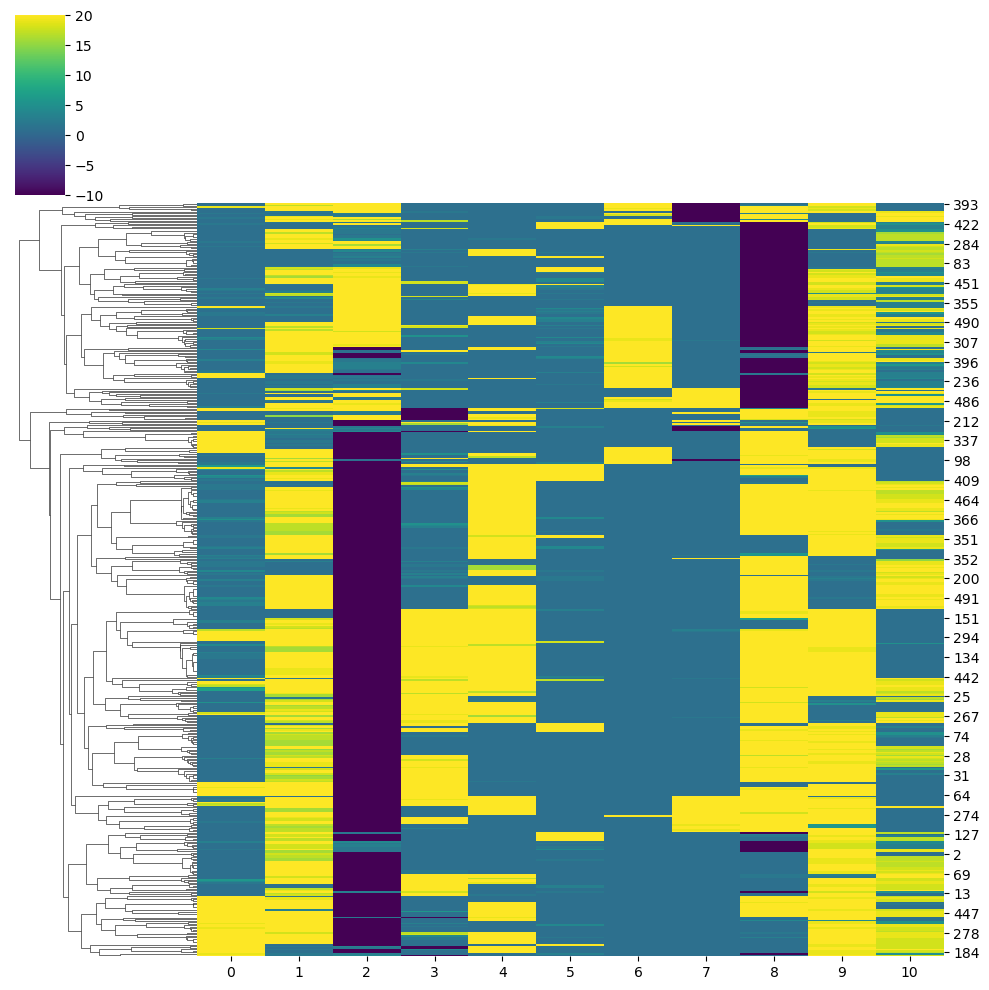

In [23]:
df_paratope_ranks_1 = pd.DataFrame(paratope_ranks_1.values())

sns.clustermap(df_paratope_ranks_1, row_cluster=True, col_cluster=False, cmap="viridis")

# sns.scatterplot(
#     data=df_paratope_ranks.melt(var_name="index", value_name="attribution_rank"),
#     x="index",
#     y="attribution_rank",
#     )

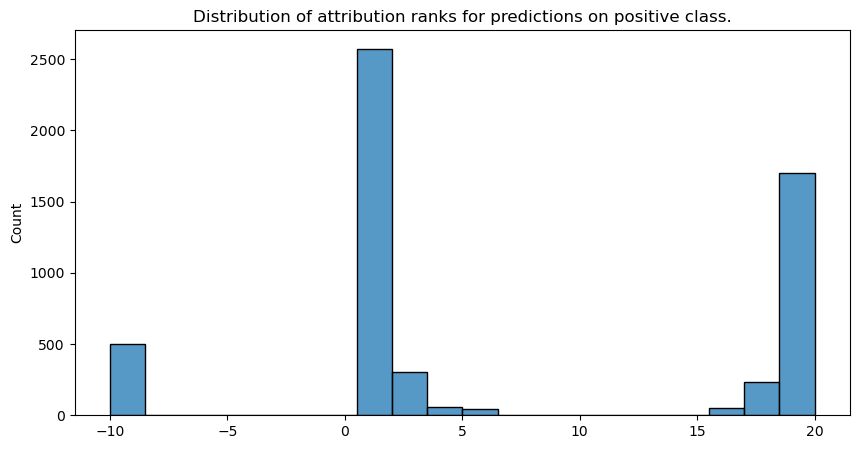

In [24]:
def plot_attr_ranks_dist(df_paratope_ranks):
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.histplot(df_paratope_ranks.values.reshape(-1), bins=20, ax=ax)
    ax.set_title("Distribution of attribution ranks for predictions on positive class.")

plot_attr_ranks_dist(df_paratope_ranks_1)

<AxesSubplot: ylabel='Frequency'>

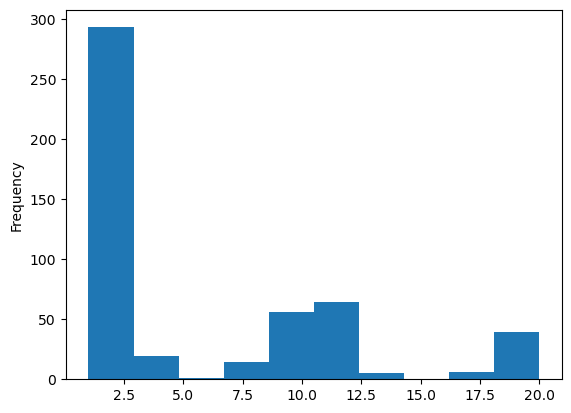

In [25]:
df_paratope_ranks_1.replace(-10, np.nan).median(axis=1, skipna=True).plot.hist()

<AxesSubplot: >

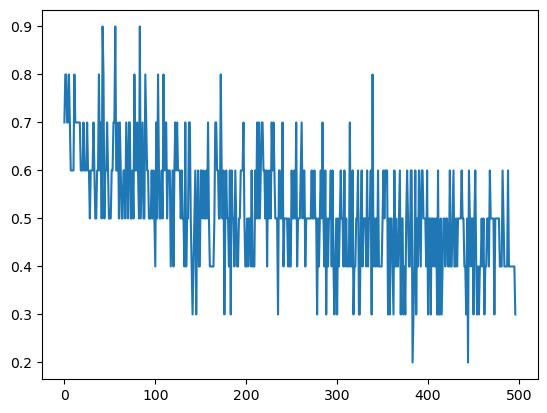

In [27]:
((df_paratope_ranks_1 == 1).sum(axis=1) / (df_paratope_ranks_1 != -10).sum(axis=1)).plot()

In [29]:
# Compute signed percent attention
attr_paratope_signpercents = []
position_aa_feature_list = []
for i, row in df_sel_2.iterrows():
    attr = row["attributions"].detach().numpy().reshape((11, 20))
    attr_signperc = attr / np.abs(attr).sum(axis=1, keepdims=True)
    
    if row["y_true"] != 1:
        continue

    try:
        paratope = preprocessing.onehot_encode_nodeg_paratope(
            preprocessing.get_no_degree_paratope(
                row["agregatesABParatope"]
            )
        ).reshape((11, 20))
    except:
        continue

    paratope = np.array(paratope, dtype=bool).reshape((11, 20))
    
    # Compute signed percent attention
    attr_paratope_signperc = attr_signperc[paratope]
    attr_paratope_signpercents.append(attr_paratope_signperc)
    
    # Record position:aminoacid feature in same order as signed percent attention
    position_aa_feature_list.append( np.argwhere(paratope).tolist() )


# Compute signed percent stats per paratope position:aminoacid feature
records = []
# Iterate per slide
for i, (feature_indexes, sgn_percents) in enumerate(zip(position_aa_feature_list, attr_paratope_signpercents)):
    # Iterate per position:aminoacid feature
    for feature_index, sgn_perc in zip(feature_indexes, sgn_percents):
        records.append({
            "slide_idx": i,
            "feature_index": feature_index,
            "sgn_perc": sgn_perc,
        })

df_sgn_perc = pd.DataFrame.from_records(records)
df_sgn_perc["feature_index_1"] = df_sgn_perc["feature_index"].apply(lambda x: x[0])
df_sgn_perc["feature_index_2"] = df_sgn_perc["feature_index"].apply(lambda x: x[1])
df_sgn_perc_stats = df_sgn_perc.groupby(["feature_index_1", "feature_index_2"])["sgn_perc"].agg(["mean", "std", "count"]).sort_values("count", ascending=False)
df_sgn_perc_stats

mean       std  count
feature_index_1 feature_index_2                           
9               19              -0.214843  0.085519    283
10              18              -0.045396  0.082068    267
0               1                0.292988  0.130010    257
7               4                0.478328  0.055273    226
6               9                0.559532  0.053267    221
...                                   ...       ...    ...
9               14              -0.734595       NaN      1
                13              -0.285430       NaN      1
                3               -0.814032       NaN      1
7               14              -0.646053       NaN      1
8               11              -0.626189       NaN      1

[177 rows x 3 columns]

<AxesSubplot: xlabel='mean', ylabel='std'>

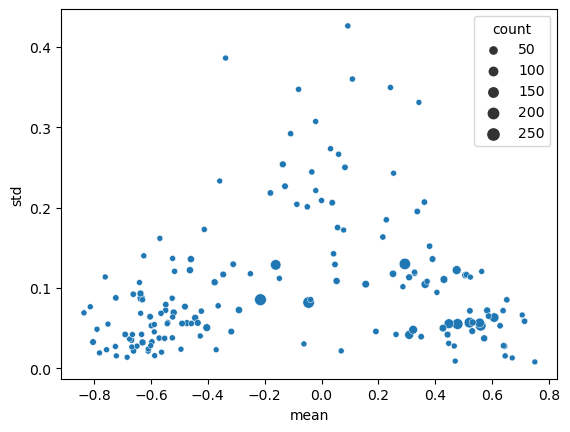

In [30]:
sns.scatterplot(
    data=df_sgn_perc_stats,
    x="mean",
    y="std",
    size="count",
)

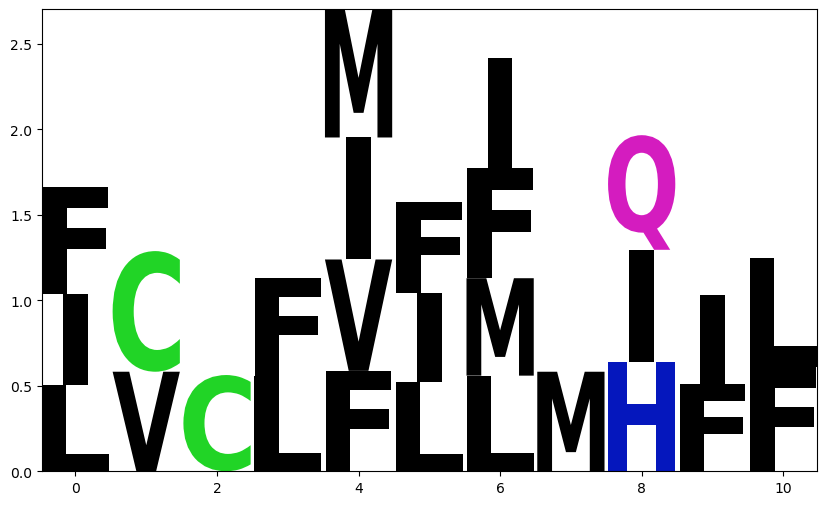

In [31]:
# Build logo for position:aminoacid features with positive mean
TH = 0.5
m = np.zeros((11, 20)) 
for i, row in df_sgn_perc_stats.loc[df_sgn_perc_stats["mean"] > TH].reset_index().iterrows():
    m[int(row["feature_index_1"]), int(row["feature_index_2"])] = row["mean"]

visualisations.plot_logo(pd.DataFrame(m, columns=config.AMINOACID_ALPHABET))

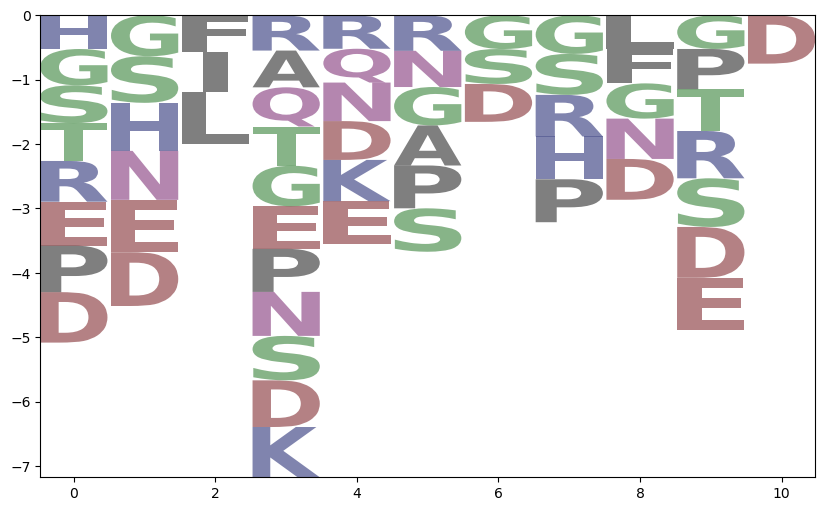

In [32]:
# Build logo for position:aminoacid features with negative mean
TH = 0.5
m = np.zeros((11, 20)) 
for i, row in df_sgn_perc_stats.loc[df_sgn_perc_stats["mean"] < -TH].reset_index().iterrows():
    m[int(row["feature_index_1"]), int(row["feature_index_2"])] = row["mean"]

visualisations.plot_logo(pd.DataFrame(m, columns=config.AMINOACID_ALPHABET))

Text(0.5, 1.0, 'Distribution of signed percent attention for paratopes')

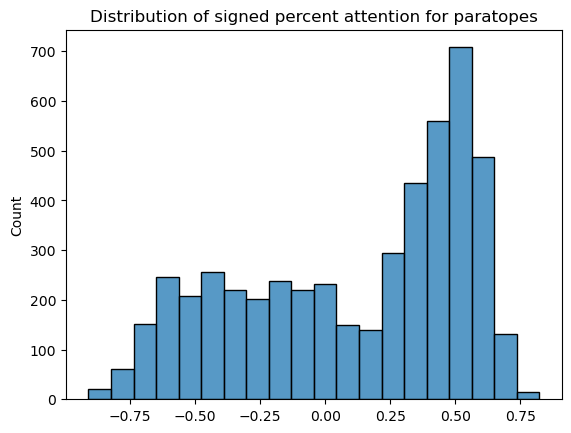

In [33]:
sns.histplot(np.concatenate(attr_paratope_signpercents), bins=20)
plt.title("Distribution of signed percent attention for paratopes")

For negative predictions, we compute the mistakes between the attributions and the paratopes.

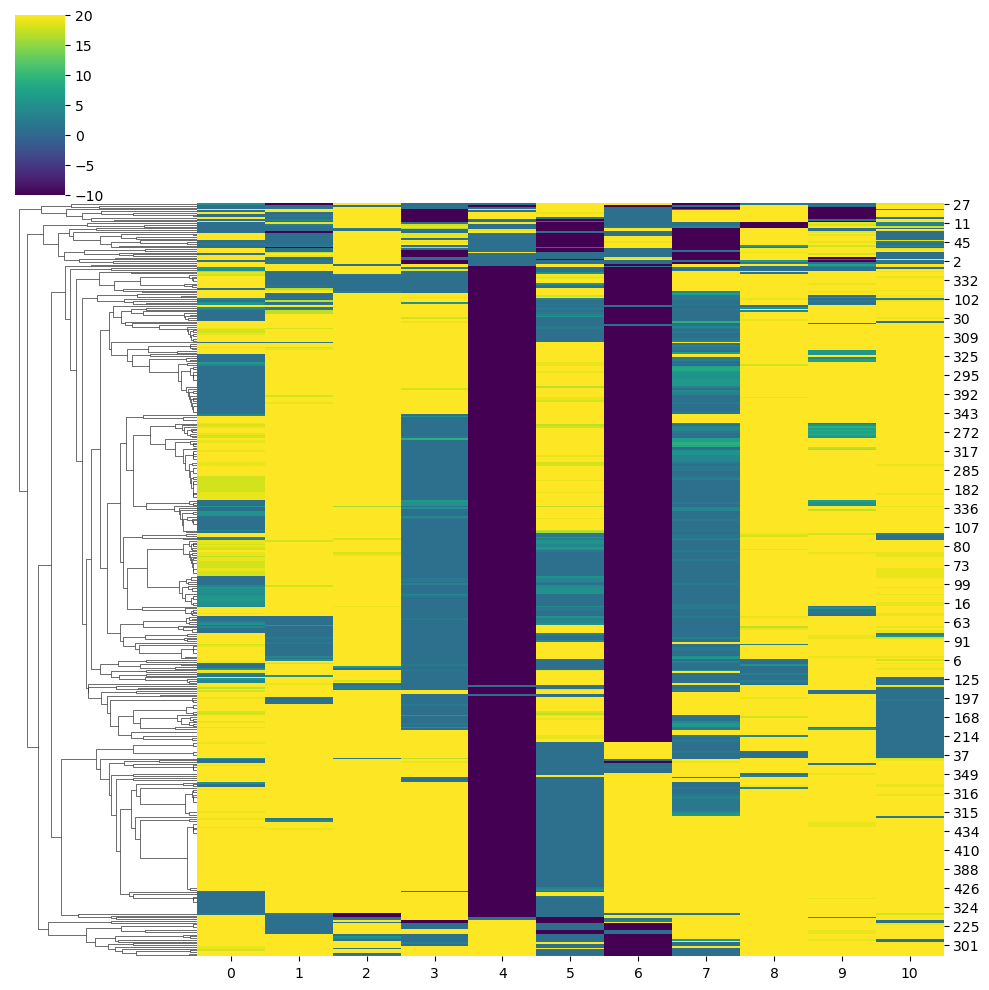

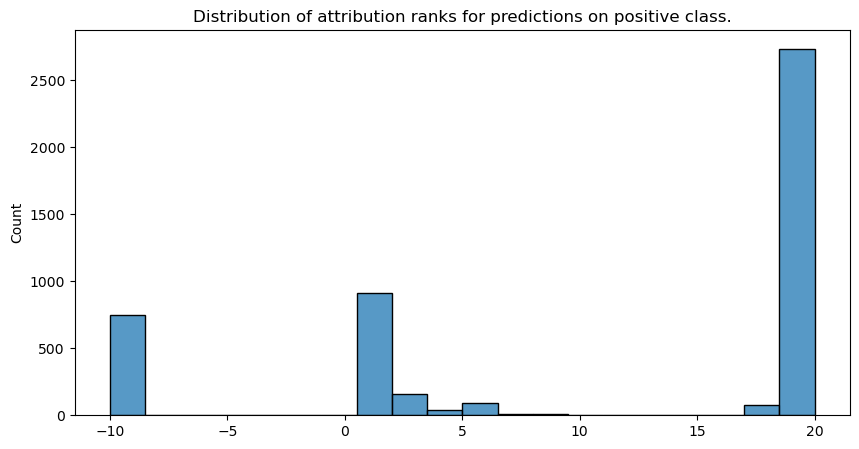

In [34]:
paratope_ranks_0 = get_paratope_ranks(0, df_sel_2)
df_paratope_ranks_0 = pd.DataFrame(paratope_ranks_0.values())
sns.clustermap(df_paratope_ranks_0, row_cluster=True, col_cluster=False, cmap="viridis")
plot_attr_ranks_dist(df_paratope_ranks_0)

<AxesSubplot: ylabel='Frequency'>

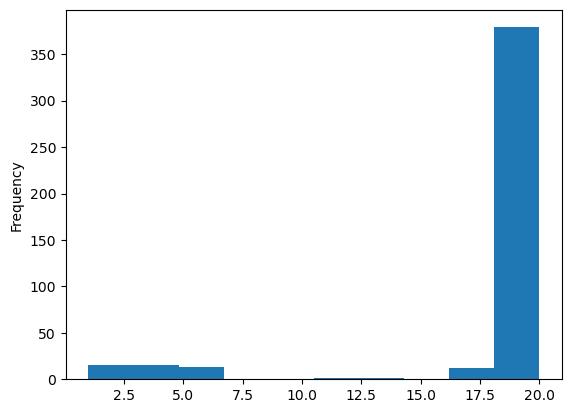

In [35]:
df_paratope_ranks_0.replace(-10, np.nan).median(axis=1, skipna=True).plot.hist()

<AxesSubplot: >

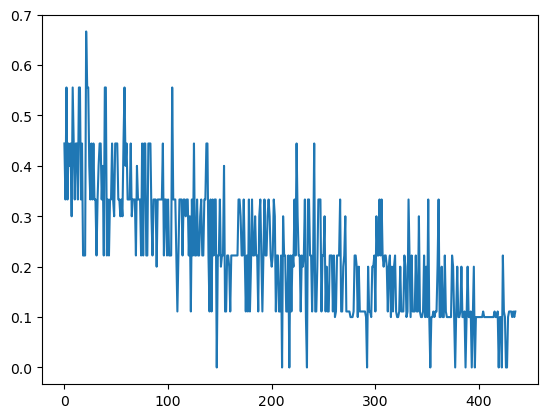

In [36]:
((df_paratope_ranks_0 == 1).sum(axis=1) / (df_paratope_ranks_0 != -10).sum(axis=1)).plot()